<table align="left">
  <td>
    <a href="https://is.gd/RPh2pV" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## En este ejemplo crearemos un **clasificador de imagenes**

**Paso 1.** Importar las librerías necesarias para implementación. 

In [16]:
import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Versión TensorFlow: " + str(tf.__version__))
print("Versión Keras: " + str(keras.__version__))

# to make this notebook's output stable across runs
np.random.seed(42)

Versión TensorFlow: 2.6.0
Versión Keras: 2.6.0


**Paso 2.** Cargar el dataset. Se utilizará el Fashion MNIST. El dataset contiene 70,000 imagenes en escala de grises de 28x28 pixeles cada una, organizadas en 10 clases.

* Se utiliza keras para cargar el dataset. 
* Se realiza la separación del batch para entrenamiento y testeo, dejando 60,000 imagenes en escala de griste de de 28x28 pixeles para el set de entrenamiento. 

In [17]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [18]:
X_train_full.shape

(60000, 28, 28)

In [19]:
# Cada pixel es representado como un byte (0 a 255):
X_train_full.dtype

dtype('uint8')

### Tratamiento de los datos
Se Divide el conjunto de entrenamiento completo en un subconjunto de validación y un subconjunto de entrenamiento (más pequeño). También se escala la intensidad de los píxeles en el rango de 0-1 y se convierten en flotantes, dividiéndolos por 255.

![Split Data](https://806230.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png )

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split((X_train_full/250.0),y_train_full, test_size=0.1)
X_test = X_test / 255.

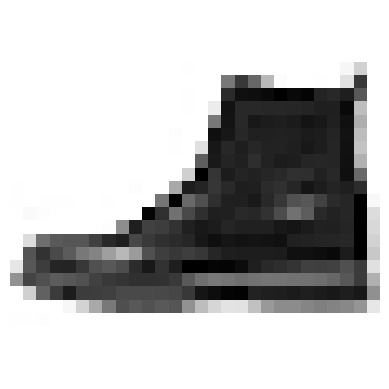

In [21]:
# se puede graficar una imagen utilizando matplotlib
plt.imshow(X_train[2], cmap="binary")
plt.axis('off')
plt.show()


#### Las etiquetas son los IDs de las clases, representados de 0 a 9. 

In [22]:
y_train

array([5, 2, 9, ..., 6, 6, 1], dtype=uint8)

In [23]:
# nombres de las clases
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# La primera imagen en el set de entrenamiento es una Coat. 
class_names[y_train[0]]

'Sandal'


El set de validación contiene 6000 imagenes, y el set de test contiene 10000 imagenes:

In [24]:
X_valid.shape

(6000, 28, 28)

In [25]:
X_test.shape

(10000, 28, 28)

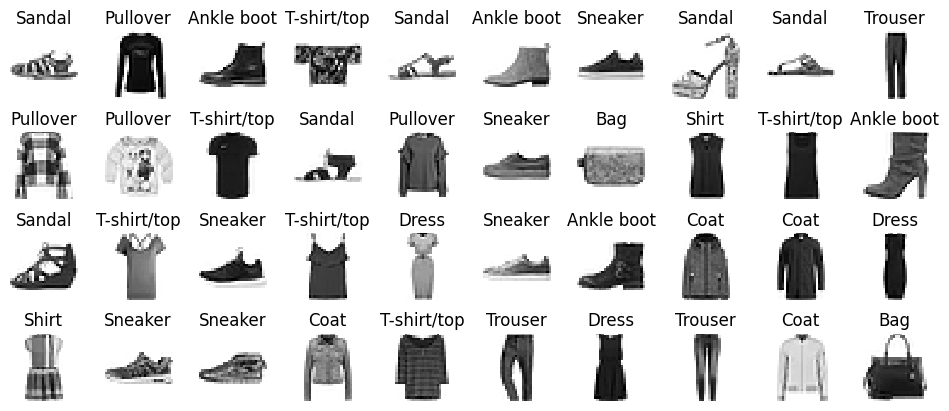

In [26]:
#Imagenes del dataset
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

**Paso 3.** Creación del modelo. 

Creamos una red para clasificación MLP con dos capas ocultas. 

Descripción de las siguientes líneas de código. 

1.   En la primera línea se crea un modelo secuencial. Este es el modelo mas sencillo de Keras y se utiliza para una red neuronal en donde las capas se conectan de manera secuencial. 

2.   En la segunda línea se crea la capa de entrada y se agrega al modelo. la función de la capa Flatten (Aplanadora) es convertir la matrix de cada imagen en un vector de una dimensión 1D. Se debe definir las dimensiónes de la matriz de entrada. 

3.   En la tercera línea se crea una capa oculta con 300 neuronas. Se utiliza la función de activación ReLU. Cada capa oculta maneja su propia matriz de pesos, contemplando todas las conexiones entre los pesos y entradas por cada neurona. Adicionalmente contiene el vector con los terminos de bias. 

4.   En la cuarta línea se agrega una segunda capa oculta con 100 neuronas, esta capa tambien utiliza la función de activación ReLU. 

5.   Finalmente, se utiliza una capa de salida con 10 neuronas (una por clase), usando la función de activación **softmax** debido a que las clases son exclusivas. 





In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dropout(0.2))  
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.layers

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

**Paso 4.** Compilando el modelo y entrenando el modelo. 

Despues de que el modelo es creado es necesario compilarlo. en el modelo se deben definir metricas que permitan calcular la perdida(error) y definir la función de optimización. 



*   **loss**: "sparse_categorical_crossentropy", se utiliza está función dado que se cuenta con un número de etiquetas escasas (sparse) - no binarias. (Binarias: categorical_crossentropy)
*   **optimizer** = Stochastic Gradient Descent (SGD) - Aplicación de backpropagation. 
*   **metrics**: dado que el modelo se utiliza para clasificar la información, se utiliza la exactitud del modelo durante el entrenamiento y la evaluación. 

Para realizar el entrenamiento se utiliza el metodo fit(). Se utilizan los datos separados para el entrenamiento (X_train, y_train), así como el número de epocas a entrenar. De forma opcional se pasa el set de validación. 

Keras medirá el valor de perdida (loss) y las metricas definidas previamente, si el desempeño con el set de entrenamiento es mucho mejor que con el set de validación, probablemente se esté presentando overfitting del set de entrenamiento.

In [31]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

### 4.1 Callbacks - Guardar el Modelo durante el entrenamiento y Early Stopping

- Al utilizar datos de validación durante el entrenamiento es posible salvar el ultimo mejor modelo.

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
- EarlyStopping 
    - patience: Number of epochs with no improvement after which training will be stopped.
    - min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- https://keras.io/api/callbacks/early_stopping/

In [32]:
#checkpoint_cb = keras.callbacks.ModelCheckpoint("fashion_model.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint("fashion_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau()

In [33]:
history = model.fit(X_train, y_train,batch_size=200, epochs=100,validation_data=(X_valid, y_valid), verbose=True, callbacks=[checkpoint_cb,reduce_lr,early_stopping_cb])

Epoch 1/100
270/270 [==============================] - 3s 8ms/step - loss: 0.5557 - accuracy: 0.7998 - val_loss: 0.4215 - val_accuracy: 0.8438
Epoch 2/100
270/270 [==============================] - 2s 7ms/step - loss: 0.3951 - accuracy: 0.8561 - val_loss: 0.4101 - val_accuracy: 0.8472
Epoch 3/100
270/270 [==============================] - 2s 7ms/step - loss: 0.3577 - accuracy: 0.8695 - val_loss: 0.3503 - val_accuracy: 0.8727
Epoch 4/100
270/270 [==============================] - 2s 7ms/step - loss: 0.3338 - accuracy: 0.8767 - val_loss: 0.3385 - val_accuracy: 0.8703
Epoch 5/100
270/270 [==============================] - 2s 7ms/step - loss: 0.3159 - accuracy: 0.8831 - val_loss: 0.3306 - val_accuracy: 0.8808
Epoch 6/100
270/270 [==============================] - 2s 7ms/step - loss: 0.3033 - accuracy: 0.8874 - val_loss: 0.3210 - val_accuracy: 0.8823
Epoch 7/100
270/270 [==============================] - 2s 7ms/step - loss: 0.2920 - accuracy: 0.8915 - val_loss: 0.3214 - val_accuracy: 0.8827

In [ ]:
history.params

{'epochs': 30, 'steps': 270, 'verbose': True}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

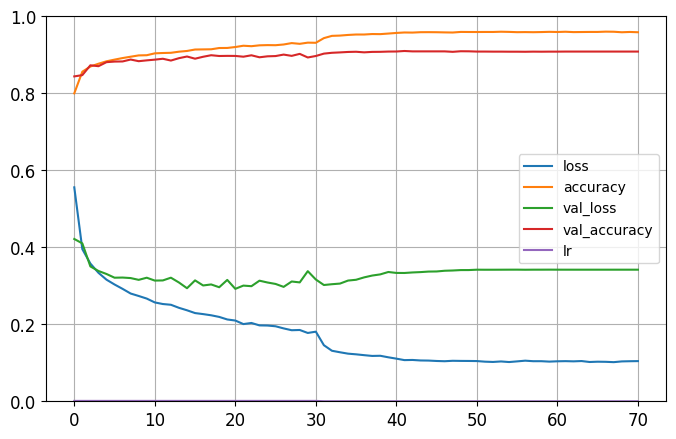

In [34]:
# se utiliza pandas para visualizar la información almacenada en el diccionario de historia de entrenamiento y graficarla. 
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Paso 5.** Evaluación del modelo. 

* Loss = Perdida (0.33)
* Accuracy = Exactitud (aprox=88.77%)

In [35]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3109 - accuracy: 0.8927


[0.3108943998813629, 0.8927000164985657]

**Paso 6.** Usando el modelo para hacer predicciones. 

Se toman 5 instancias del set de prueba para hacer la predicción. y se imprime la matriz de probabilidad para cada una de las instancias. 

In [40]:
X_new = X_test[10:15]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.06, 0.  , 0.91, 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.87, 0.  , 0.01, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [42]:
classes_x = np.argmax(y_proba,axis=1)

In [43]:
# Valores predichos
np.array(class_names)[classes_x]

array(['Coat', 'Sandal', 'Sandal', 'Dress', 'Coat'], dtype='<U11')

In [45]:
y_new = y_test[10:15]
y_new

array([4, 5, 7, 3, 4], dtype=uint8)

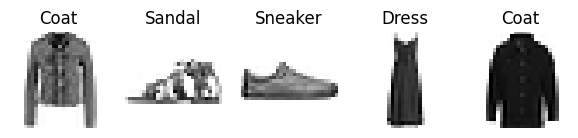

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_new[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

**Paso 6.** Guardar el Modelo. 
Este metodo funcionará con las API secuencial y funcional de keras. Para modelos mas complejos se puede utilizar las funciones **save_weights() y load_weights().**

In [ ]:
model.save("fashion_Model.h5")

**Paso 7.** Cargar el Modelo. 


In [ ]:
model = keras.models.load("fashion_Model.h5")